### Table Content
------------------

- [Introduction](#intro)
- [Import libraries and packages](#ilp)
- [Dataset Information](#di)
- [Separate 'Title' field and preprocess it](#preprocess)
    - [Removing unwanted charaters and words](#remv)
    - [Tokenization and word_index (vocabulary) ](#token)
    - [Convert titles into sequences and Make n_gram model](#ngram)
    - [Make all titles with same length and padding them](#pad)
- [Preprare features (X) and labels (Y)](#xy)
- [Architechture of Bidirectional LSTM neural network](#blstm)
- [Train Bi-LSTM neural network](#train)
- [Plotting accuracy and loss graph](#acc)
- [Predict new title (Testing)](#new)

----------------




<a name="intro"></a>

# Introduction

**Next Word Prediction (also called Language Modeling) is the task of predicting what word comes next. It is one of the fundamental tasks of NLP.**


It is poosible through natural language processing (NLP) technique. Here, we will use NLP and try to make a prediction model using Bidirectional LSTM (Long short-term memory) model that will predict next words of sentence.


<a name="ilp"></a>
# Import necessary libraries and packages

In [1]:
!pip install kaggle
!pip install pandas
!pip install numpy
!pip install tensorflow
!pip install keras
!pip install seaborn

In [2]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

<a name="di"></a>
# Dataset information

**Import Medium-articles-dataset:**

This dataset contains information about randomly chosen medium articles published in 2019 from these 7 publications:

- Towards Data Science
- UX Collective
- The Startup
- The Writing Cooperative
- Data Driven Investor
- Better Humans
- Better Marketing


In [3]:
!kaggle datasets download -d dorianlazar/medium-articles-dataset

Dataset URL: https://www.kaggle.com/datasets/dorianlazar/medium-articles-dataset
License(s): CC0-1.0
100% 1.32G/1.33G [00:59<00:00, 16.7MB/s]
100% 1.33G/1.33G [00:59<00:00, 23.9MB/s]


In [4]:
import zipfile
import os

# Define the path to the zip file and the extraction path
zip_path = 'medium-articles-dataset.zip'
extract_path = 'medium-articles-dataset'

# Create a directory for the extracted files
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)


Files extracted to: medium-articles-dataset


In [5]:
medium_data = pd.read_csv('medium-articles-dataset/medium_data.csv')
medium_data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


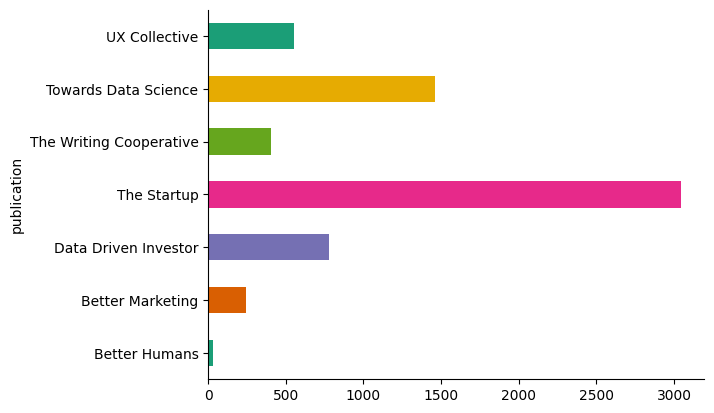

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
medium_data.groupby('publication').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Here, we have a **10 different fields and 6508 records** but we will only use **title field** for predicting next word.

In [9]:
print("Number of records: ", medium_data.shape[0])
print("Number of fields: ", medium_data.shape[1])

Number of records:  6508
Number of fields:  10


<a name="preprocess"></a>
# Display titles of various articles  and preprocess them

In [10]:
medium_data['title']

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

<a name="remv"></a>
#### Removing unwanted characters and words in titles

Looking at titles, we can see there are some of unwanted characters and words in it which can not be useful for us to predict infact it might decrease our model accuracy so we have to remove it.

In [11]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))

<a name="token"></a>
#### Tokenzation

Tokenzaion is the process in which we provide an unique id to all the words and make a word index or we can say vocabulary.

In [12]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1
total_words

8238

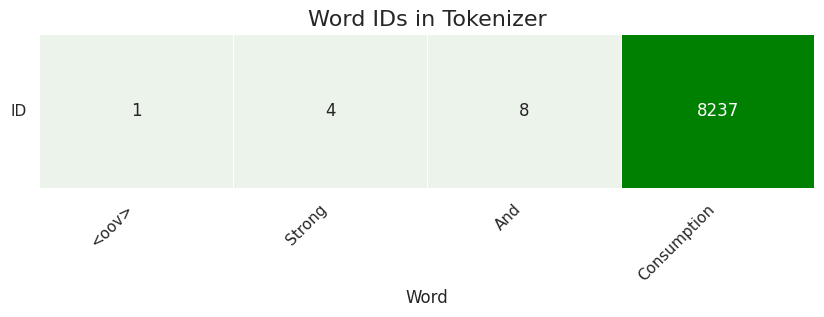

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dictionary with your data
data = {
    'Word': ['<oov>', 'Strong', 'And', 'Consumption'],
    'ID': [
        tokenizer.word_index['<oov>'],
        tokenizer.word_index['strong'],
        tokenizer.word_index['and'],
        tokenizer.word_index['consumption']
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a larger figure to better see details
plt.figure(figsize=(10, 2))

# Title for the table
plt.title('Word IDs in Tokenizer', fontdict={'fontsize': 16})

# Use seaborn's color palette for better visuals
cm = sns.light_palette("green", as_cmap=True)

# Display the DataFrame as a more visually appealing table
s = sns.heatmap(df.set_index('Word').T, annot=True, fmt="d", cmap=cm, linewidths=.5, cbar=False)

# Hide x labels and tick labels for top axes and y ticks for right axes
s.set_yticklabels(s.get_yticklabels(), rotation=0)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

# Remove the 'ID' label for cleaner aesthetics
s.yaxis.label.set_visible(False)

plt.show()


<a name="ngram"></a>
#### Titles text into sequences and make n_gram model

suppose, we have sentence like **"I am Yash"** and this will convert into a sequence with their respective tokens **{'I': 1,'am': 2,'Yash': 3}**. Thus, output will be  **[ '1' ,'2' ,'3' ]**

Likewise, our all titles will be converted into sequences.

Then, we will make a n_gram model for good prediction.

In [16]:
input_sequences = []
for line in medium_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)

    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  48461


<a name="pad"></a>
#### Make all titles with same length by using padding

The length of every title has to be the same. To make it, we need to find a title that has a maximum length, and based on that length, we have to pad rest of titles.

In [17]:
# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 676,
        68], dtype=int32)

<a name="xy"></a>
# Prepare features and labels

Here, we consider **last element of all sequences as a label**.Then,
We need to perform **onehot encoding on labels corresponding to total_words.**

In [18]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [19]:
print(xs[5])
print(labels[5])
print(ys[5][14])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    5  676   68    2  452 1518]
14
1.0


<a name="blstm"></a>
# Architechture of Bidirectional LSTM Neural Network

Long Short-Term Memory (LSTM) networks is an advance recurrent neural network which is apable to store order states by using its cell state feature.

<a name="train"></a>
# Bi- LSTM Neural Network Model training

In [20]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=50, verbose=1)
#print model.summary()
print(model)


Epoch 1/50
1515/1515 [==============================] - 91s 58ms/step - loss: 7.0002 - accuracy: 0.0839
Epoch 2/50
1515/1515 [==============================] - 88s 58ms/step - loss: 6.1639 - accuracy: 0.1383
Epoch 3/50
1515/1515 [==============================] - 87s 57ms/step - loss: 5.6507 - accuracy: 0.1663
Epoch 4/50
1515/1515 [==============================] - 89s 59ms/step - loss: 5.1787 - accuracy: 0.1883
Epoch 5/50
1515/1515 [==============================] - 90s 59ms/step - loss: 4.7264 - accuracy: 0.2165
Epoch 6/50
1515/1515 [==============================] - 87s 58ms/step - loss: 4.3025 - accuracy: 0.2470
Epoch 7/50
1515/1515 [==============================] - 89s 59ms/step - loss: 3.9019 - accuracy: 0.2897
Epoch 8/50
1515/1515 [==============================] - 88s 58ms/step - loss: 3.5272 - accuracy: 0.3383
Epoch 9/50
1515/1515 [==============================] - 88s 58ms/step - loss: 3.1748 - accuracy: 0.3939
Epoch 10/50
1515/1515 [==============================] - 88s 58m

<a name="acc"></a>
# Plotting model accuracy and loss

In [21]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

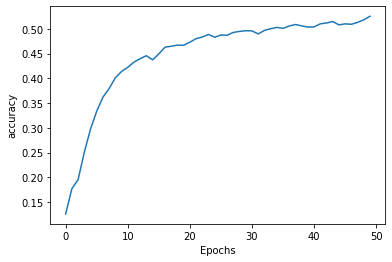

In [ ]:
plot_graphs(history, 'accuracy')

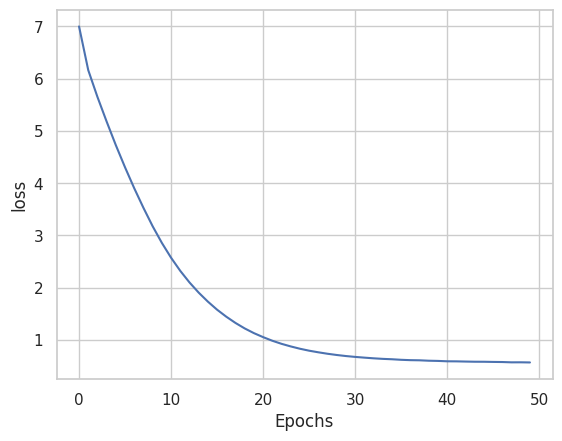

In [22]:
plot_graphs(history, 'loss')

<a name="new"></a>
# Predicting next word of title

In [24]:
seed_text = "implementation of"
next_words = 2

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predictions = model.predict(token_list, verbose=0)
    predicted = np.argmax(predictions, axis=-1)  # Get the index of the max probability
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)


implementation of rnn lstm


In [25]:
model.save("inline-text-prediction-50")

In [29]:
from google.colab import files

# !zip -r inline-text-prediction-50.zip inline-text-prediction-50
files.download("inline-text-prediction-50.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>